<a href="https://colab.research.google.com/github/ds4geo/ds4geo/blob/master/WS%202020%20Course%20Notes/Session%206.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Science for Geoscientists - Winter Semester 2020**
# **Session 6 - Smoothing and Filtering - 11th November 2020**

Last week we looked at resampling and interpretation. A key application of these methods is to allow timeseries to be directly compared. Another important part of working with timeseries data (amongst others!) is filtering and smoothing. We often work with data with a significant noise component which must be removed to allow meaningful analysis or visualisation.

Instead of using Numpy, we will use Pandas from the begining, starting with an overview of how to use Pandas for the resampling and interpolation tasks from last week.

# Part 6.1 - Resampling with Pandas - *Walkthrough*


In [143]:
import pandas as pd
import matplotlib.pyplot as plt


In [144]:
air_temp = pd.read_excel("https://github.com/ds4geo/ds4geo/raw/master/data/timeseries/Au%C3%9Fenluft%2BEingangslabyrinth.xlsx",
                         sheet_name="Daten3", usecols=[0,6], names=["time", "air_temp"])
cave_temp = pd.read_excel("https://github.com/ds4geo/ds4geo/raw/master/data/timeseries/Au%C3%9Fenluft%2BEingangslabyrinth.xlsx",
                          sheet_name="Daten3", usecols=[8,9], names=["time", "cave_temp"])
cave_CO2 = pd.read_excel("https://github.com/ds4geo/ds4geo/raw/master/data/timeseries/CO2%20_compiled.xlsx",
                         sheet_name="Data Stream (2)", names=["time", "unknown", "d13C", "d18O", "ppm CO2", "ctime"])

## Part 6.1.1 - Upsampling outside air temperature data
Here we use Pandas to upsample the outside air temperature data to 15 minute intervals.

In [145]:
# drop blank data
air_temp = air_temp.dropna(axis=0)

# drop duplicates
air_temp.drop_duplicates("time", inplace=True)

# Set datetime index
air_temp.index = air_temp.time


In [146]:
# Resample to 15 minutes and interpolate the gaps
air_15m = air_temp["air_temp"].resample("15T").interpolate("cubic") # linear, cubic, quadratic, linear, slinear,

(5.0, 22.0)

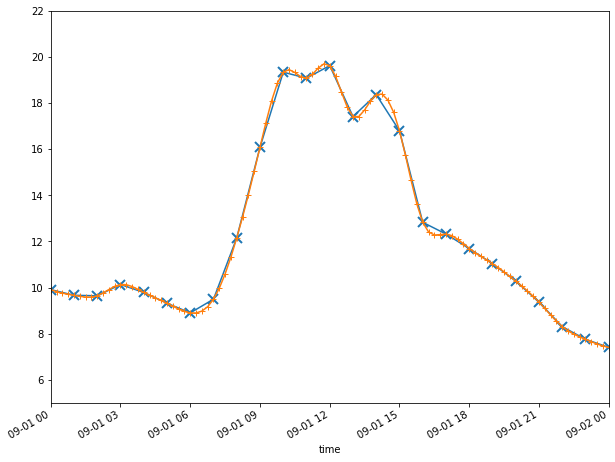

In [147]:
# Compare the original and resampled data
fig, ax = plt.subplots(figsize=(10,8))
air_temp["air_temp"].plot(ax=ax, marker="x", markersize=10, markeredgewidth=2)
air_15m.plot(ax=ax, marker="+")
ax.set_xlim("2015-09-01","2015-09-02")
ax.set_ylim(5,22)


## Part 6.1.2 - Downsampling Cave CO2 data
Here we downsample the cave CO2 data to 15 minute intervals.


In [148]:
# drop blank data
cave_CO2 = cave_CO2.dropna(axis=0)

# drop duplicates
cave_CO2.drop_duplicates("time", inplace=True)

# Set datetime index
cave_CO2.index = cave_CO2.time

In [149]:
# Resample and interpolate
CO2_15m = cave_CO2["ppm CO2"].resample("15T").interpolate("linear")

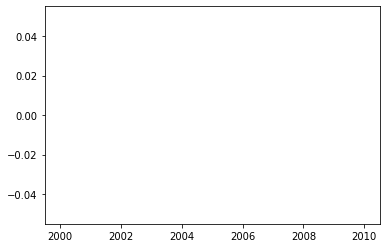

In [150]:
# Doesn't work - usually bad idea to downsample by interpolation
plt.plot(CO2_15m)

In [151]:
# downsample by aggregation
CO2_15m = cave_CO2["ppm CO2"].resample("15T").agg("mean")

(735860.0, 735863.0)

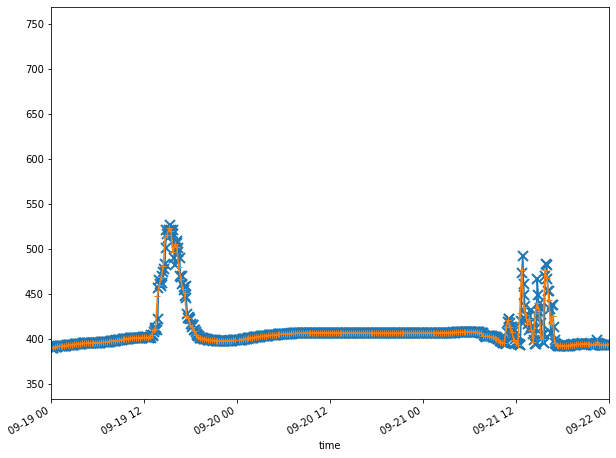

In [152]:
# Compare before and after resampling
fig, ax = plt.subplots(figsize=(10,8))
cave_CO2["ppm CO2"].plot(ax=ax, marker="x", markersize=10, markeredgewidth=2)
CO2_15m.plot(ax=ax, marker="+")
ax.set_xlim("2015-09-19","2015-09-22")


## Part 6.1.3 - Downsampling the cave temperature data

In [153]:
# drop blank data
cave_temp = cave_temp.dropna(axis=0)

# drop duplicates
cave_temp.drop_duplicates("time", inplace=True)

# Set datetime index
cave_temp.index = cave_temp.time

In [154]:
# Resample to 20 minutes and interpolate
cave_20m = cave_temp["cave_temp"].resample("20T").interpolate("nearest")

(3.5, 4.5)

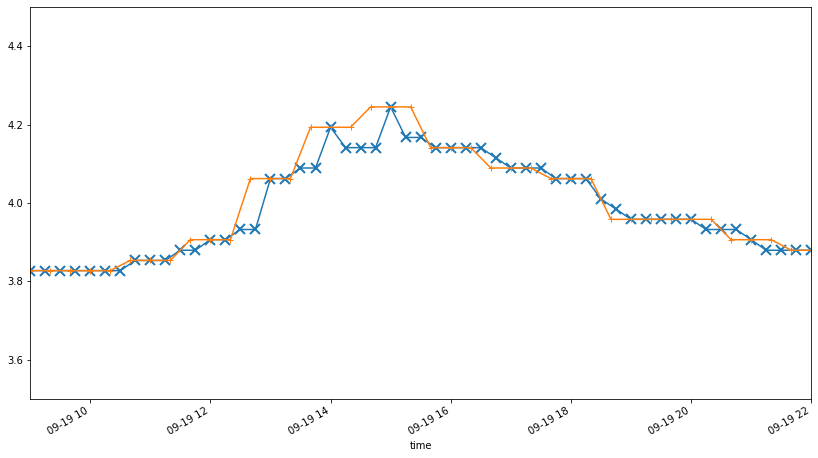

In [155]:
# Compare before and after resampling
fig, ax = plt.subplots(figsize=(14,8))
cave_temp["cave_temp"].plot(ax=ax, marker="x", markersize=10, markeredgewidth=2)
cave_20m.plot(ax=ax, marker="+")
ax.set_xlim("2015-09-19 09","2015-09-19 22")
ax.set_ylim(3.5,4.5)
# WARNING! interpolating like this with Pandas behaves differently to Numpy
# The resample step drops existing data which isn't aligned with the new intervals
# In numpy this data can be considered.
# Even more reason to use agg!

In [156]:
# Resample to 20 minutes and aggregate
cave_20m = cave_temp["cave_temp"].resample("20T").agg("nearest")

(3.5, 4.5)

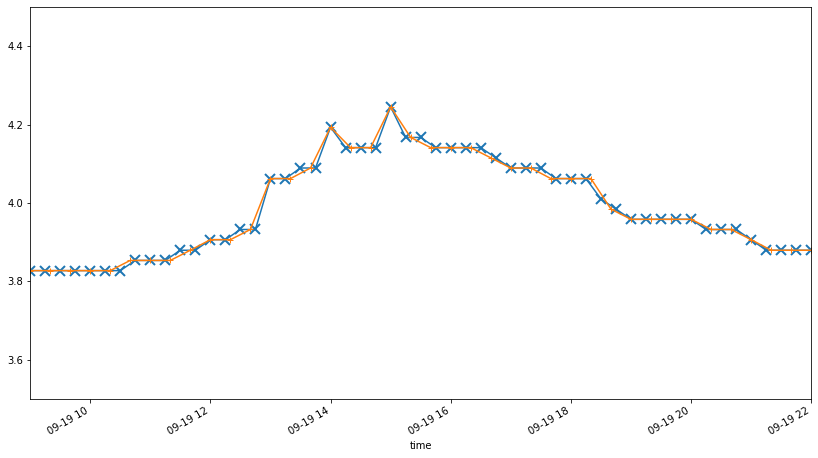

In [157]:
# Compare before and after resampling
fig, ax = plt.subplots(figsize=(14,8))
cave_temp["cave_temp"].plot(ax=ax, marker="x", markersize=10, markeredgewidth=2)
cave_20m.plot(ax=ax, marker="+")
ax.set_xlim("2015-09-19 09","2015-09-19 22")
ax.set_ylim(3.5,4.5)

#Part 6.2 - Introduction to data filtering - *Mini-lecture*

* Most common: moving/rolling averages
* Make a moving/rolling "window", and take average of values in window for each position across dataset.
* Simple application in Numpy:
 * Filter of 1/n (n=filter length)
 * convolve filter with data
* Simple application in Pandas:
 * `pd.DataFrame.rolling().mean()`

#Part 6.3 - Data filtering excercise - *Walkthrough/Workshop*
We will apply a simple moving average filter on a noisy dataset to smooth it.

You can either use a dataset of your choice (e.g. from the student submitted datasets), or use the following XRF core scanning data from an Antarctic sediment core: "https://doi.pangaea.de/10.1594/PANGAEA.859980?format=textfile " (V is particularly noisy).

1. Constuct a "window" object on the noisy data using `pd.DataFrame.rolling()`.

2. Using the window object, apply a moving average smoothing using `.mean()`

3. Plot the original and smoothed data.

4. Experiment with different window lengths.

In [161]:
dat = pd.read_csv("https://doi.pangaea.de/10.1594/PANGAEA.859980?format=textfile", sep="\t", header=48)

In [178]:
dat.index = dat["Depth [m]"]

In [179]:
dat.head()

,Pos [mm],Depth [m],Al [cps],Si [cps],P [cps],S [cps],Cl [cps],Ar [cps],K [cps],Ca [cps],Ti [cps],V [cps],Cr [cps],Mn [cps],Fe [cps],Cu [cps],Zn [cps],Ga [cps],Ge [cps],Rb [cps],Sr [cps],Y [cps],Zr [cps],Pd [cps],Ba [cps],Ce [cps],Nd [cps],Sm [cps],Hf [cps],Ta [cps],W [cps],Pt [cps],Au [cps],Pb [cps],Th [cps],U [cps]
Depth [m],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0000,512.75,0.0000,0,201,14,19,16,49,1541,1069,1219,4,26,571,51169,69,245,213,207,1677,1500,566,1478,46,72,0,4,31,0,395,1082,213,67,117,0,82
0.0003,513.05,0.0003,20,202,0,31,34,72,1708,1178,1360,45,49,641,53353,33,310,266,252,1858,1773,435,1358,52,0,0,21,7,24,458,1333,233,0,166,24,46
0.0006,513.35,0.0006,12,180,37,27,31,68,1693,1182,1293,39,29,600,54124,81,285,377,317,1585,1785,395,1180,51,35,10,0,0,4,387,1348,280,126,68,72,36
0.0009,513.65,0.0009,0,175,26,46,27,84,1739,1224,1380,0,63,630,55493,140,263,352,100,1654,1750,500,1246,42,12,0,0,0,0,330,1357,322,76,109,91,47
0.0012,513.95,0.0012,12,166,0,31,25,77,1637,1196,1265,48,49,676,54022,84,369,269,292,1762,1560,482,1006,32,5,23,0,17,12,369,1135,267,114,6,56,53


In [180]:
dat["Depth [m]"].max()

0.7143

In [181]:
V = dat["V [cps]"]

In [182]:
V_3pt = V.rolling(3).mean()

In [183]:
V_3pt

Depth [m]
0.0000          NaN
0.0003          NaN
0.0006    29.333333
0.0009    28.000000
0.0012    29.000000
            ...    
0.7131     4.333333
0.7134     4.333333
0.7137     2.000000
0.7140     2.000000
0.7143     4.333333
Name: V [cps], Length: 2382, dtype: float64

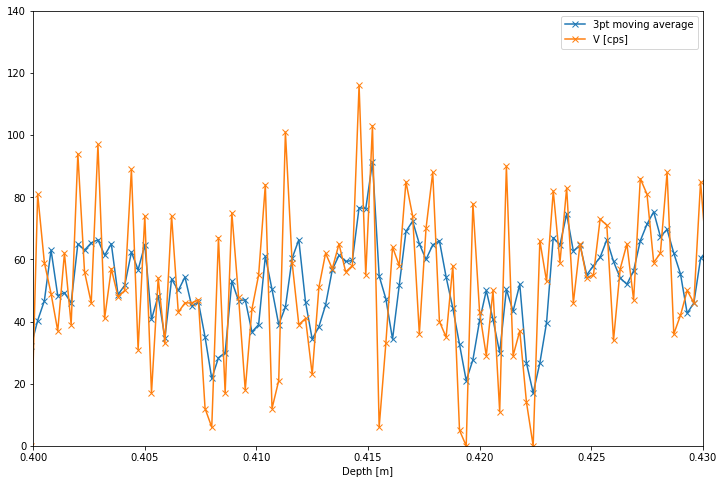

In [190]:
fig, ax = plt.subplots(figsize=(12,8))
V_3pt.plot(ax=ax, label="3pt moving average", marker="x")
V.plot(ax=ax, marker="x")
ax.set_xlim(0.4, 0.43)
ax.set_ylim(0,140)
ax.legend()

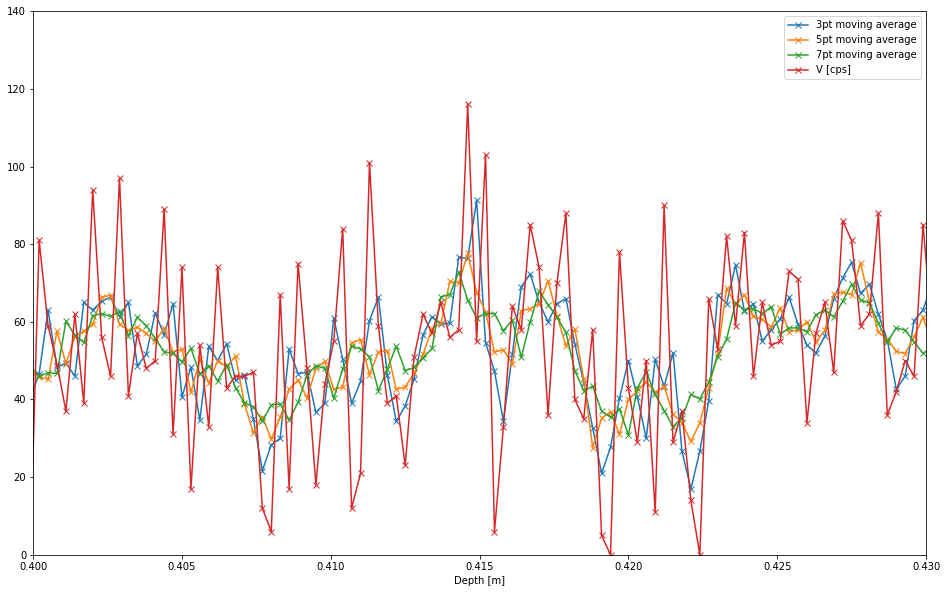

In [206]:
filter_lengths = range(3,21,2)#[3, 5, 7, 9, 11, 21 ,91]

smoothed = []
for fl in filter_lengths:
  temp_smoothed = V.rolling(fl, center=True).mean()
  smoothed.append(temp_smoothed)

# compare
fig, ax = plt.subplots(figsize=(16,10))
for d, fl in zip(smoothed, filter_lengths):
  d.plot(ax=ax, label="{}pt moving average".format(fl), marker="x")
V.plot(ax=ax, marker="x")
ax.set_xlim(0.4, 0.43)
ax.set_ylim(0,140)
ax.legend()

# Part 6.4 - Advanced filtering - *Mini-lecture*
* Moving average filters equally weight importance of all data in the window.
* However, probably want to weight central points more than distant ones.
* Many more complex filter shapes exist, e.g. those in assignment task 1.
* Filtering is also possible in frequency domain with Fourier Transforms – not addressed in this course.


# Part 6.5 - Advanced filtering excercise - *Walkthrough/Workshop*

Pandas allows us to apply lots of different complex filters/window shapes from the scipy.signal toolbox: https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows

Experiment with these filters and different lengths and compare them to moving average filters on the dataset from the previous section, or one of your own choosing. Investigate and comment on the differences and value of each approach.

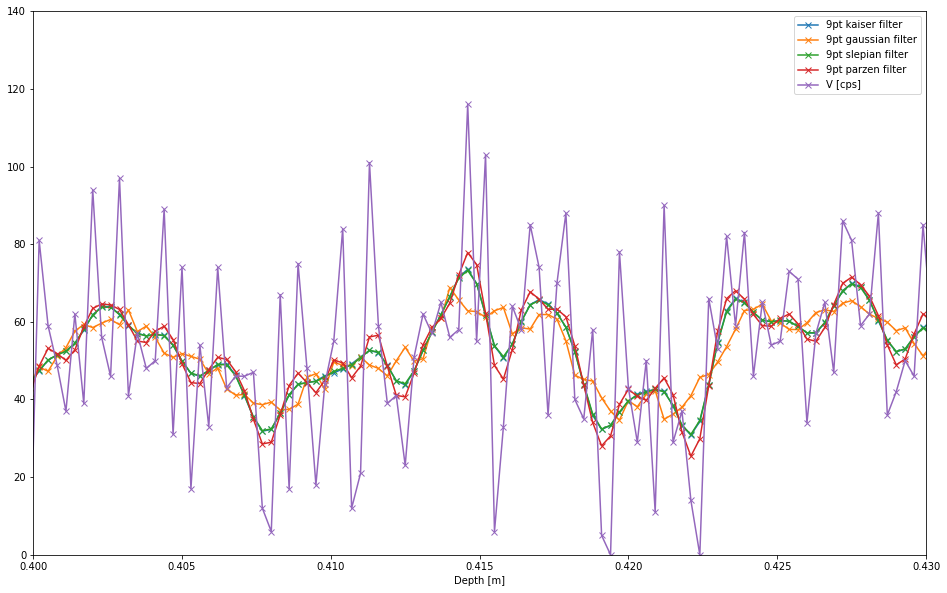

In [229]:
window_types = [{"name":"kaiser", "param": {"beta": 5}},
                {"name":"gaussian", "param": {"std": 5}},
                {"name":"slepian", "param": {"width": 5}},
                {"name":"parzen", "param": {"":""}}
                ]#, "parzen", "flattop", "gaussian", "slepian"]
filter_length = 9


smoothed = []
for wt in window_types:
  temp_smoothed = V.rolling(filter_length, win_type = wt["name"], center=True).mean(**wt["param"])
  smoothed.append(temp_smoothed)

# compare
fig, ax = plt.subplots(figsize=(16,10))
for d, wt in zip(smoothed, window_types):
  d.plot(ax=ax, label="{}pt {} filter".format(filter_length, wt["name"]), marker="x")
V.plot(ax=ax, marker="x")
ax.set_xlim(0.4, 0.43)
ax.set_ylim(0,140)
ax.legend()

# Week 6 "Assignment"

Next week we will discuss the weather data story telling assignment from week 3 and the topic of story telling with data. The assignment next week will be to expand upon your assignment 3 submissions.

Until next week, you are encouraged to keep looking at each other's week 3 submissions and providing further feedback, and you can also start working on the further analyses and story structure.

THe assignment will be properly explained next week, but you can:
* expand your analysis to more cities
* go into more detail on the original cities you chose
* focus on improving the narative and structure of your story

The assignment was and will be about telling an interesting and compelling story with data. Many nice plots were created, but few really created a compelling narative supported by the data. A clear story told with simple plots an analyses is often more effective than fancy plots without a good narative.